In [1]:
import pickle
import eli5
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

In [2]:
def write_submission_to_file(y_pred, outfile, 
                             target='target', index_label='session_id'):
    '''Helper func to wrtie predicted to a file.
    '''
    predicted_df = pd.DataFrame(y_pred, 
                                index=np.arange(1, y_pred.shape[0] + 1), 
                                columns=[target])
    
    predicted_df.to_csv(outfile, index_label=index_label)
    
    return 0

In [3]:
PATH_TO_DATA = '../../data'
SEED = 17

# READ training and test sets.

In [4]:
cols = ['{}{}'.format(prefix, i) for prefix in ('site', 'time') for i in range(1, 11)]

sites, times = cols[:10], cols[10:]

In [5]:
def read_data(filename):
    '''Read data from csv files into the dataframes.
    '''
    path = '../../data/'
    return pd.read_csv(path + filename, index_col='session_id', parse_dates=times)

#### Read.

In [6]:
train_df, test_df = [read_data(filename) for filename in ('train_sessions.csv', 
                                                          'test_sessions.csv')]

In [7]:
# Load websites dictionary
with open(r'../../data/site_dic.pkl', 'rb') as _file:
    site_dict = pickle.load(_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [8]:
sites_dict.head()

,site
13388,i1-js-14-3-01-12165-151301868-i.init.cedexis-r...
39125,glitterfly.com.s3.amazonaws.com
13458,i1-js-14-3-01-12160-345976407-i.init.cedexis-r...
5478,b.huffingtonpost.com
4886,sebsauvage.net


#### Sort train.

In [9]:
# Sort the data by starting session times.
train_df = train_df.sort_values(by='time1')

#### Reindex.

In [10]:
old_index_train = train_df.index

train_df = train_df.reset_index().drop('session_id', axis=1)
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
3,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
4,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


#### Save split index.

In [11]:
# Index to split train in test datasets.
idx_split = train_df.shape[0]
idx_split

253561

#### Merge both data sets in one. Manage indices.

In [12]:
# Merge data sets in one united full data set.
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# NOTE!!!
# To avoid duplicates in index (aka session_id, taken from train and test)
full_df = full_df.set_index(np.arange(full_df.shape[0]))
full_df['site1'] = full_df['site1'].astype('float64')

full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,56.0,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
1,56.0,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
2,946.0,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17
3,945.0,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20
4,947.0,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22


# Alice and not-Alice indices.

In [13]:
not_alice_index = train_df[train_df.target == 0].index
alice_index = train_df[train_df.target == 1].index

not_alice_index.shape, alice_index.shape

((251264,), (2297,))

#### Separate target values from train set.

In [14]:
# Save train target in a separate vector.
y_train = train_df.target

#### Create separate time_df to work with timestamps.

In [15]:
time_df = full_df[times]
time_df.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
2,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
3,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
4,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22


#### Drop times fields and keep only sites for the model.

In [16]:
full_df = full_df[sites]

In [17]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
full_df = full_df.fillna(0).astype(np.uint16)
full_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
0,56,55,0,0,0,0,0,0,0,0
1,56,55,56,55,0,0,0,0,0,0
2,946,946,951,946,946,945,948,784,949,946
3,945,948,949,948,945,946,947,945,946,946
4,947,950,948,947,950,952,946,951,946,947


#### sites SPARSE matrix.

In [18]:
sites_flatten = full_df.values.flatten()

full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0], 
                               sites_flatten, 
                               range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

full_sites_sparse.shape

(336358, 48371)

# Make NEW features.

#### Duration of session.

In [19]:
# Find min and max time points in each session,
# and calculate sessions` duration.
full_df_new_features = pd.DataFrame(index=full_df.index)
full_df_new_features['start'] = time_df[times].min(axis=1)
full_df_new_features['end'] = time_df[times].max(axis=1)
full_df_new_features['duration_sec'] = full_df_new_features.end - full_df_new_features.start
full_df_new_features.head()

,start,end,duration_sec
0,2013-01-12 08:05:57,2013-01-12 08:05:57,00:00:00
1,2013-01-12 08:37:23,2013-01-12 09:07:09,00:29:46
2,2013-01-12 08:50:13,2013-01-12 08:50:17,00:00:04
3,2013-01-12 08:50:17,2013-01-12 08:50:20,00:00:03
4,2013-01-12 08:50:20,2013-01-12 08:50:22,00:00:02


In [20]:
# Convert time in sec to int.
full_df_new_features.duration_sec = full_df_new_features.duration_sec.dt.total_seconds()
full_df_new_features.head()

,start,end,duration_sec
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
3,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
4,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


#### Statistic about duration for alices' sessions.

In [21]:
alice_dur_stats = full_df_new_features.loc[alice_index, ['duration_sec']]
alice_75pr_dur = float(alice_dur_stats.describe().T[['75%']].values)

print('75% of alices` durations: {}\n\n{}'.format(alice_75pr_dur, alice_dur_stats.head()))

75% of alices` durations: 38.0

      duration_sec
3568         437.0
3630          26.0
3634          53.0
3636           3.0
3637          30.0


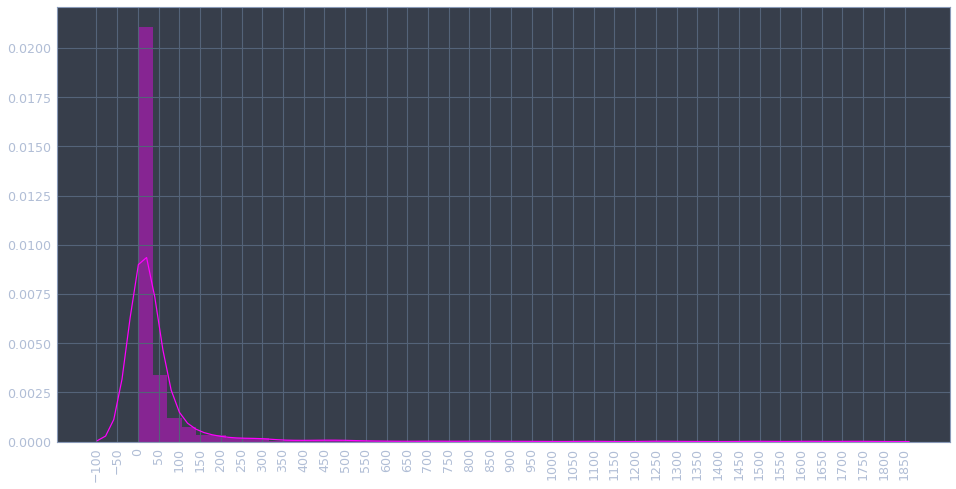

In [22]:
plt.figure(figsize=(16, 8))
plt.xticks(range(-100, 1900, 50), rotation=90)
sns.distplot(full_df_new_features.loc[alice_index, ['duration_sec']], 
             bins=50, hist=True, kde=True, color='magenta');

In [23]:
tmp_thrs = alice_75pr_dur * 1.44
tmp_thrs

54.72

In [24]:
full_df_new_features['if_alice_dur'] = full_df_new_features.duration_sec\
    .apply(lambda sec: 1 if sec <= tmp_thrs else 0)

full_df_new_features.head(3)

,start,end,duration_sec,if_alice_dur
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,1
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1


#### Unique sites by a session.

In [25]:
full_df_new_features['unique'] = full_df[sites].stack()\
                                 .groupby(level=0)\
                                 .nunique()\
                                 .astype('float64')

full_df_new_features.head()

,start,end,duration_sec,if_alice_dur,unique
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,1,3.0
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0,3.0
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1,6.0
3,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,1,5.0
4,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,1,6.0


In [26]:
alice_unique = full_df_new_features.unique.loc[alice_index].value_counts(normalize=True)
notalice_unique = full_df_new_features.unique.loc[not_alice_index].value_counts(normalize=True)

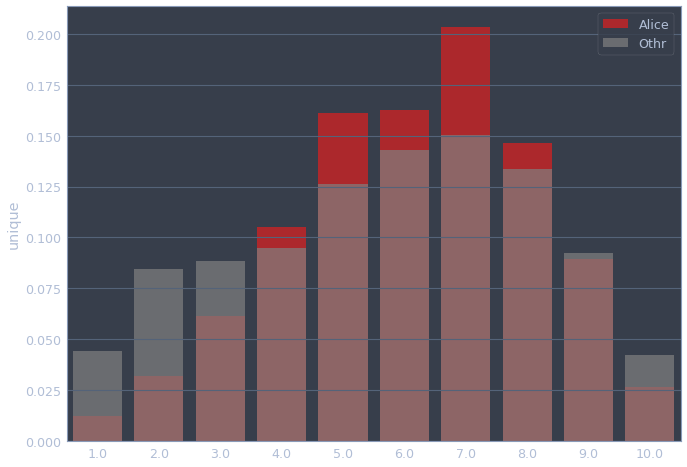

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8), sharex=True)

_alice = sns.barplot(x=alice_unique.index, y=alice_unique, 
                     color='red', alpha=.7, label='Alice')
_others = sns.barplot(x=notalice_unique.index, y=notalice_unique, 
                      color='grey', alpha=.7, label='Othr')

plt.legend()
plt.show();

In [28]:
full_df_new_features['log_uniq'] = full_df_new_features['unique']\
    .apply(lambda num: np.log(num))

full_df_new_features.log_uniq.describe()

count    336358.000000
mean          1.596074
std           0.577040
min           0.000000
25%           1.386294
50%           1.791759
75%           2.079442
max           2.302585
Name: log_uniq, dtype: float64

#### Duration/unique

In [29]:
full_df_new_features['dur/unique'] = \
    full_df_new_features.duration_sec / \
    full_df_new_features['unique']

full_df_new_features.head()

,start,end,duration_sec,if_alice_dur,unique,log_uniq,dur/unique
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,1,3.0,1.098612,0.000000
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0,3.0,1.098612,595.333333
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1,6.0,1.791759,0.666667
3,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,1,5.0,1.609438,0.600000
4,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,1,6.0,1.791759,0.333333


#### Start month into dummies.

In [30]:
full_df_new_features['start_month'] = time_df.time1\
    .apply(lambda ts: ts.year*100 + ts.month).astype('float64')

In [31]:
tmp_df = pd.get_dummies(full_df_new_features['start_month'])
tmp_df.shape

(336358, 24)

In [32]:
start_month_sparse = csr_matrix(tmp_df)

# # If scale sparse matrix
# start_month_sparse = StandardScaler(with_mean=False).fit_transform(start_month_sparse)

start_month_sparse.shape

(336358, 24)

#### Start hour.

In [33]:
full_df_new_features['start_hour'] = time_df.time1\
    .apply(lambda ts: ts.hour).astype('float64')

full_df_new_features.head()

,start,end,duration_sec,if_alice_dur,unique,log_uniq,dur/unique,start_month,start_hour
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,1,3.0,1.098612,0.000000,201301.0,8.0
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0,3.0,1.098612,595.333333,201301.0,8.0
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1,6.0,1.791759,0.666667,201301.0,8.0
3,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,1,5.0,1.609438,0.600000,201301.0,8.0
4,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,1,6.0,1.791759,0.333333,201301.0,8.0


In [34]:
start_hour_dummies = pd.get_dummies(full_df_new_features['start_hour'])
start_hour_sparse = csr_matrix(start_hour_dummies)
start_hour_sparse.shape

(336358, 17)

#### If started in the morning, day, eveninig or night.

In [35]:
full_df_new_features['morning'] = full_df_new_features.start_hour\
    .apply(lambda hour: 1 if hour <= 11 else 0)
full_df_new_features['day'] = full_df_new_features.start_hour\
    .apply(lambda hour: 1 if (12 <= hour <= 18) else 0)
full_df_new_features['evening'] = full_df_new_features.start_hour\
    .apply(lambda hour: 1 if (19 <= hour <= 23) else 0)
full_df_new_features['night'] = full_df_new_features.start_hour\
    .apply(lambda hour: 1 if (0 <= hour <= 6) else 0)

#### Specific start hours for Alice.

In [36]:
alice_start_hour = train_df.time1.apply(lambda ts: ts.hour).values[y_train == 1]
notalice_start_hour = train_df.time1.apply(lambda ts: ts.hour).values[y_train == 0]

alice_start_hour.shape, notalice_start_hour.shape

((2297,), (251264,))

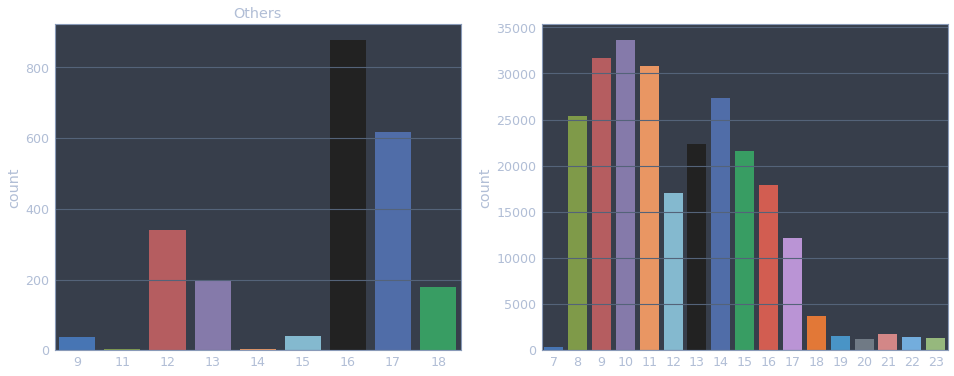

In [37]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

sns.countplot(alice_start_hour, ax=ax0)
ax0.set_title('Alice')
sns.countplot(notalice_start_hour, ax=ax1)
ax0.set_title('Others')

plt.show();

In [38]:
pd.DataFrame(alice_start_hour)[0].value_counts().sort_index()

9      38
11      3
12    340
13    196
14      4
15     40
16    879
17    618
18    179
Name: 0, dtype: int64

In [39]:
full_df_new_features['alice_hours'] = \
    time_df.time1.apply(lambda ts: 1 if (15 < ts.hour < 18) else 0)

full_df_new_features['not_alice_early'] = \
    time_df.time1.apply(lambda ts: 1 if (ts.hour < 12) else 0)

full_df_new_features['not_alice_middle'] = \
    time_df.time1.apply(lambda ts: 1 if (16 > ts.hour > 13) else 0)

full_df_new_features['not_alice_late'] = \
    time_df.time1.apply(lambda ts: 1 if (ts.hour > 18) else 0)

In [40]:
print('Alice hours: \n{}\n'
      'Early morning: \n{}\n'
      'Day middle: \n{}\n'
      'Late night: \n{}'
      .format(full_df_new_features['alice_hours'].value_counts(normalize=True),
      full_df_new_features['not_alice_early'].value_counts(normalize=True),
      full_df_new_features['not_alice_middle'].value_counts(normalize=True),
      full_df_new_features['not_alice_late'].value_counts(normalize=True)))

Alice hours: 
0    0.87323
1    0.12677
Name: alice_hours, dtype: float64
Early morning: 
0    0.525975
1    0.474025
Name: not_alice_early, dtype: float64
Day middle: 
0    0.803843
1    0.196157
Name: not_alice_middle, dtype: float64
Late night: 
0    0.97173
1    0.02827
Name: not_alice_late, dtype: float64


In [41]:
full_df_new_features['hour/dur'] = full_df_new_features.start_hour / full_df_new_features.duration_sec
full_df_new_features['hour/dur'] = full_df_new_features['hour/dur']\
    .apply(lambda num: 24 if num > 99999 else num)

In [42]:
full_df_new_features.head()

,start,end,duration_sec,if_alice_dur,unique,log_uniq,dur/unique,start_month,start_hour,morning,day,evening,night,alice_hours,not_alice_early,not_alice_middle,not_alice_late,hour/dur
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,1,3.0,1.098612,0.000000,201301.0,8.0,1,0,0,0,0,1,0,0,24.000000
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0,3.0,1.098612,595.333333,201301.0,8.0,1,0,0,0,0,1,0,0,0.004479
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1,6.0,1.791759,0.666667,201301.0,8.0,1,0,0,0,0,1,0,0,2.000000
3,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,1,5.0,1.609438,0.600000,201301.0,8.0,1,0,0,0,0,1,0,0,2.666667
4,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,1,6.0,1.791759,0.333333,201301.0,8.0,1,0,0,0,0,1,0,0,4.000000


#### Weekday start.

In [43]:
full_df_new_features['start_day'] = time_df.time1.apply(pd.datetime.weekday)

In [44]:
full_df_new_features.head(4)

,start,end,duration_sec,if_alice_dur,unique,log_uniq,dur/unique,start_month,start_hour,morning,day,evening,night,alice_hours,not_alice_early,not_alice_middle,not_alice_late,hour/dur,start_day
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,1,3.0,1.098612,0.000000,201301.0,8.0,1,0,0,0,0,1,0,0,24.000000,5
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0,3.0,1.098612,595.333333,201301.0,8.0,1,0,0,0,0,1,0,0,0.004479,5
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1,6.0,1.791759,0.666667,201301.0,8.0,1,0,0,0,0,1,0,0,2.000000,5
3,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,1,5.0,1.609438,0.600000,201301.0,8.0,1,0,0,0,0,1,0,0,2.666667,5


In [45]:
# Which day more often is start for alices` sessions.
alice_weekday = full_df_new_features.loc[alice_index, ['start_day']].astype('float64').sort_index()
not_alice_weekday = full_df_new_features.loc[not_alice_index, ['start_day']].astype('float64').sort_index()

not_alice_weekday.shape, alice_weekday.shape

((251264, 1), (2297, 1))

In [46]:
not_alice_weekday.head(4)

,start_day
0,5.0
1,5.0
2,5.0
3,5.0


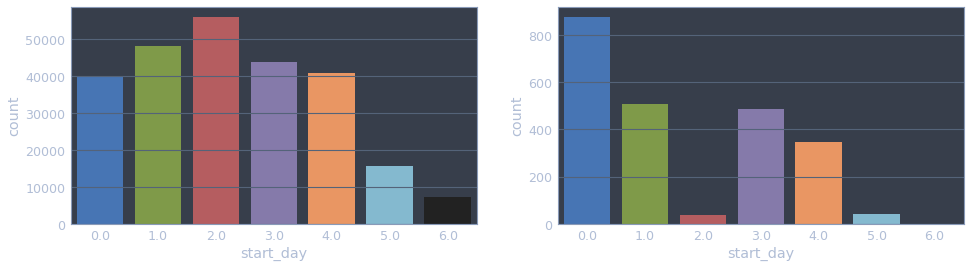

In [47]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

sns.countplot(ax=ax0, data=not_alice_weekday, x='start_day')
sns.countplot(ax=ax1, data=alice_weekday, x='start_day')

plt.show();

#### NOT Alice WEEKday

In [48]:
def check_weekday(day):
    if day == 0:
        return 'Mn'
    elif day in (2, 5, 6):
        return 'Wd|St|Sn'
    else:
        return 'else'

In [49]:
full_df_new_features['alices_weekday'] = full_df_new_features.start_day\
    .apply(lambda day: check_weekday(day))

full_df_new_features[['start_day', 'alices_weekday']].head()

,start_day,alices_weekday
0,5,Wd|St|Sn
1,5,Wd|St|Sn
2,5,Wd|St|Sn
3,5,Wd|St|Sn
4,5,Wd|St|Sn


In [50]:
if_alices_weekday_feature = pd.get_dummies(full_df_new_features.alices_weekday)
if_alices_weekday_feature.shape

(336358, 3)

In [51]:
full_df_new_features.drop(['start_day', 'alices_weekday'], axis=1, inplace=True)
full_df_new_features[['Mn', 'Wd|St|Sn', 'else']] = if_alices_weekday_feature[:]

full_df_new_features.head()

,start,end,duration_sec,if_alice_dur,unique,log_uniq,dur/unique,start_month,start_hour,morning,...,evening,night,alice_hours,not_alice_early,not_alice_middle,not_alice_late,hour/dur,Mn,Wd|St|Sn,else
0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,1,3.0,1.098612,0.000000,201301.0,8.0,1,...,0,0,0,1,0,0,24.000000,0,1,0
1,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0,3.0,1.098612,595.333333,201301.0,8.0,1,...,0,0,0,1,0,0,0.004479,0,1,0
2,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1,6.0,1.791759,0.666667,201301.0,8.0,1,...,0,0,0,1,0,0,2.000000,0,1,0
3,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,1,5.0,1.609438,0.600000,201301.0,8.0,1,...,0,0,0,1,0,0,2.666667,0,1,0
4,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,1,6.0,1.791759,0.333333,201301.0,8.0,1,...,0,0,0,1,0,0,4.000000,0,1,0


#### Analyse what site more freq is start and finish point in Alice sessions.

In [52]:
alice_sorted_start_site = full_df.loc[alice_index, ['site1']]\
    ['site1']\
    .value_counts().sort_values(ascending=False)

notalice_sorted_start_site = full_df.loc[not_alice_index, ['site1']]\
    ['site1']\
    .value_counts().sort_values(ascending=False)

top_alice_sites = alice_sorted_start_site.reset_index()
top_notalice_sites = notalice_sorted_start_site.reset_index()

In [53]:
tmp_top = top_alice_sites['index'].head()
sites_dict.loc[tmp_top]

,site
80,s.youtube.com
77,i1.ytimg.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


In [54]:
tmp_top = top_notalice_sites['index'].head()
sites_dict.loc[tmp_top]

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
29,www.facebook.com
22,apis.google.com


In [55]:
alice_sorted_start_site.head(11)

80     142
77     141
76     130
29      98
21      80
22      56
81      54
23      51
879     47
82      43
881     40
Name: site1, dtype: int64

In [56]:
notalice_sorted_start_site.head(11)

21     13794
23      9193
782     7769
29      5403
22      5378
167     5083
780     4407
778     3790
52      3761
812     3515
570     3285
Name: site1, dtype: int64

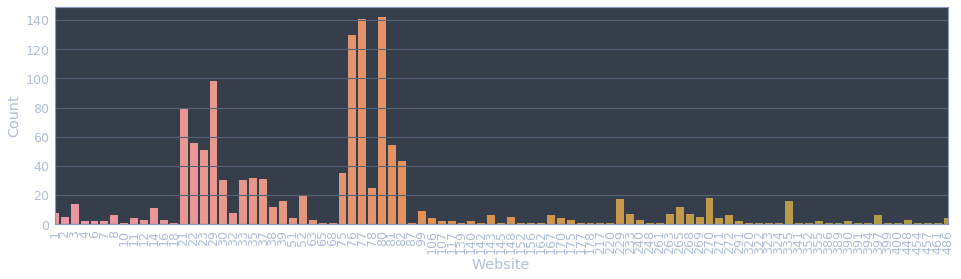

In [57]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=True)

sns.barplot(ax=ax, data=top_alice_sites, x='index', y='site1')

ax.set(xlim=(0, 90), xlabel="Website", ylabel="Count")

plt.xticks(rotation=90);

In [58]:
full_df_new_features['if_alice_site1'] = full_df['site1']\
    .apply(lambda site: 1 if site in (80, 77, 76) else 0)

#### Find out what is 0 site index.

In [59]:
full_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
0,56,55,0,0,0,0,0,0,0,0
1,56,55,56,55,0,0,0,0,0,0
2,946,946,951,946,946,945,948,784,949,946
3,945,948,949,948,945,946,947,945,946,946
4,947,950,948,947,950,952,946,951,946,947


In [60]:
def real_last_site(line):
    '''Find real last visited site in a session.
    '''
    sample = list(line[1])
    try:
        return sample[sample.index(0)-1]
    except ValueError:
        return sample[-1]

In [61]:
full_df['real_last_site'] = [real_last_site(line) for line in full_df.stack().groupby(level=0)]

In [62]:
alice_sorted_finish_site = full_df.loc[alice_index, ['real_last_site']]\
    ['real_last_site']\
    .value_counts().sort_values(ascending=False)

alice_sorted_finish_site.head()

77    151
76    138
80    137
21     93
29     84
Name: real_last_site, dtype: int64

In [63]:
notalice_sorted_finish_site = full_df.loc[not_alice_index, ['real_last_site']]\
    ['real_last_site']\
    .value_counts().sort_values(ascending=False)

notalice_sorted_finish_site.head()

21     12863
23      8519
782     7797
22      5871
29      5359
Name: real_last_site, dtype: int64

In [64]:
full_df_new_features['not_alice_last_site'] = \
    full_df.real_last_site.apply(lambda site: 1 if site in (23, 782, 22) else 0)

full_df_new_features['not_alice_last_site'].value_counts(normalize=True)

0    0.911868
1    0.088132
Name: not_alice_last_site, dtype: float64

In [65]:
full_df_new_features['alice_last_site'] = \
    full_df.real_last_site.apply(lambda site: 1 if site in (77, 76, 80) else 0)

full_df_new_features['alice_last_site'].value_counts(normalize=True)

0    0.970957
1    0.029043
Name: alice_last_site, dtype: float64

#### find most freq chains of sites in alices` sessions.

In [66]:
others_top = ['782|782|782|782|782|782|782|782|782|782', 
              '953|953|953|953|953|953|953|953|953|953', 
              '3290|3290|3290|3290|3290|3290|3290|3290|3290|3290', 
              '786|786|786|786|786|786|786|786|786|786']

In [67]:
try:
    pd.DataFrame(full_df[sites], alice_index)\
        .stack()\
        .groupby(level=0)\
        .apply(lambda chain: '|'.join(list(map(str, chain))))\
        .value_counts()\
        .sort_values(ascending=False)\
        .loc[others_top]
except KeyError:
    print('There`re no such sites` chain in alices` sessions!')

There`re no such sites` chain in alices` sessions!


In [68]:
sites_dict.loc[[782, 953, 3290, 786]]

,site
782,annotathon.org
953,download.jboss.org
3290,api.twitter.com
786,www.phylogeny.fr


In [69]:
pd.DataFrame(full_df[sites], not_alice_index)\
    .stack()\
    .groupby(level=0)\
    .apply(lambda chain: '|'.join(list(map(str, chain))))\
    .value_counts()\
    .sort_values(ascending=False)\
    .loc[others_top]

782|782|782|782|782|782|782|782|782|782              2738
953|953|953|953|953|953|953|953|953|953               823
3290|3290|3290|3290|3290|3290|3290|3290|3290|3290     756
786|786|786|786|786|786|786|786|786|786               735
dtype: int64

In [70]:
full_df_new_features['not_alice_chain'] = full_df[sites]\
    .stack()\
    .groupby(level=0)\
    .apply(lambda chain: '|'.join(list(map(str, chain))))\
    .apply(lambda chain: 1 if chain in others_top else 0)

In [71]:
full_df_new_features['not_alice_chain'].value_counts()

0    330012
1      6346
Name: not_alice_chain, dtype: int64

# SCALE the new features.

In [72]:
full_df_new_features.head(1)[1:].T

""
start
end
duration_sec
if_alice_dur
unique
log_uniq
dur/unique
start_month
start_hour
morning


In [73]:
# include = ['if_alice_dur', 'morning', 'day', 'evening', 
include = ['if_alice_dur', 'morning', 'day', 'evening', 
           'alice_hours', 'not_alice_early', 'not_alice_middle', 'not_alice_late',
           'Mn', 'Wd|St|Sn', 'else',
           'if_alice_site1', 'not_alice_last_site', 'alice_last_site', 'log_uniq']
to_scale = ['duration_sec']

In [74]:
new_features_scaled = StandardScaler()\
    .fit_transform(full_df_new_features[to_scale].astype('float64'))

new_features_scaled.shape

(336358, 1)

In [75]:
pd.DataFrame(new_features_scaled).head()

,0
0,-0.468611
1,5.622634
2,-0.454969
3,-0.458380
4,-0.461790


# manage VALIDATION scheme.

In [76]:
time_split = TimeSeriesSplit(n_splits=10)

#### Train the model with cross-validation scheme.

In [77]:
full_df_new_features[include].iloc[:idx_split, :].head()
# new_features_scaled[:idx_split, :].shape

,if_alice_dur,morning,day,evening,alice_hours,not_alice_early,not_alice_middle,not_alice_late,Mn,Wd|St|Sn,else,if_alice_site1,not_alice_last_site,alice_last_site,log_uniq
0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1.098612
1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1.098612
2,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1.791759
3,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1.609438
4,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1.791759


In [78]:
X_train = csr_matrix(hstack(
    [full_sites_sparse[:idx_split, :],
     start_month_sparse[:idx_split, :],
     new_features_scaled[:idx_split, :],
     full_df_new_features[include].iloc[:idx_split, :]]))

X_train.shape

(253561, 48411)

In [79]:
# C_opt = 0.1668100537200059
# C_opt = 0.21544346900318834
# C_opt = 0.8531678524172814
# C_opt = 2.8072162039411785
# C_opt = 0.1373823795883263
# C_opt = 0.28942661247167517
C_opt = 2.424462017082328

In [80]:
logit = LogisticRegression(C=C_opt, random_state=SEED, solver='liblinear')

In [81]:
def check_cv_scores(X_train, y_train=y_train, cv=time_split):
    %time
    cv_scores = cross_val_score(logit, 
                                X_train, y_train, 
                                cv=time_split, 
                                scoring='roc_auc', 
                                n_jobs=-1)
    
    return cv_scores, cv_scores.mean(), cv_scores.std()

In [82]:
print(check_cv_scores(X_train))
# print(check_cv_scores(X_train_poly))
# [print(check_cv_scores(X)) for X in (X_train, X_train_poly)];

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.1 µs
(array([0.84672297, 0.85206522, 0.89843754, 0.96514263, 0.92993395,
       0.97423452, 0.91273599, 0.9619794 , 0.94827976, 0.97545567]), 0.9264987647408811, 0.04560185778234112)


## Feature importance.

In [83]:
logit.fit(X_train, y_train)

LogisticRegression(C=2.424462017082328, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [84]:
feature_importance = pd.DataFrame(logit.coef_).T

In [85]:
print('All features: ', feature_importance.shape[0])
print('Sites sparse matrix: ', full_sites_sparse.shape[1])
print('Start month sparse matrix: ', start_month_sparse.shape[1])
print(to_scale, new_features_scaled.shape[1])
print(include, full_df_new_features[include].shape[1])


All features:  48411
Sites sparse matrix:  48371
Start month sparse matrix:  24
['duration_sec'] 1
['if_alice_dur', 'morning', 'day', 'evening', 'alice_hours', 'not_alice_early', 'not_alice_middle', 'not_alice_late', 'Mn', 'Wd|St|Sn', 'else', 'if_alice_site1', 'not_alice_last_site', 'alice_last_site', 'log_uniq'] 15


In [86]:
features_counter = len(to_scale) + len(include)  # include features (scaled + not scaled).

include_coef = feature_importance[-features_counter:]
include_coef.T

,48395,48396,48397,48398,48399,48400,48401,48402,48403,48404,48405,48406,48407,48408,48409,48410
0,-0.199311,0.022048,-2.828929,-1.214931,-2.559564,1.311717,-2.828929,-2.839863,-2.559564,-0.534862,-3.991082,-2.07748,0.266482,0.072427,0.178873,1.322907


In [87]:
feature_names = to_scale + include

feature_importance = feature_importance.iloc[-features_counter:, :]
feature_importance['name'] = feature_names
feature_importance.columns = ['coef', 'name']
feature_importance.sort_values(by='coef', ascending=False)

,coef,name
48410,1.322907,log_uniq
48400,1.311717,alice_hours
48407,0.266482,if_alice_site1
48409,0.178873,alice_last_site
48408,0.072427,not_alice_last_site
48396,0.022048,if_alice_dur
48395,-0.199311,duration_sec
48404,-0.534862,Mn
48398,-1.214931,day
48406,-2.077480,else


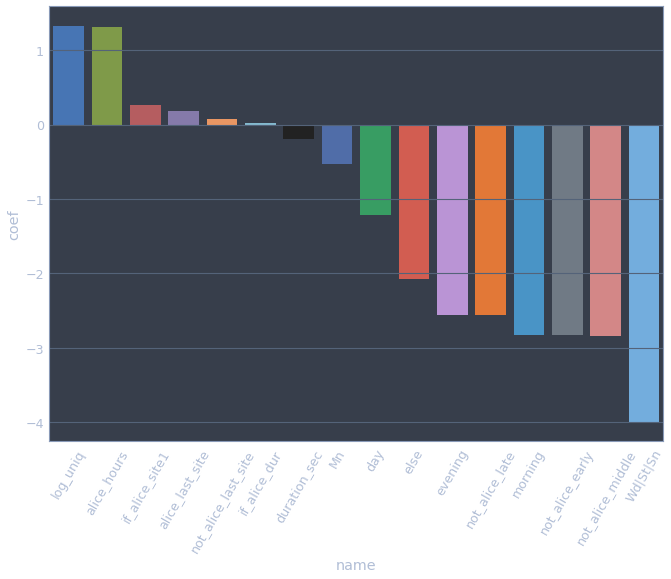

In [88]:
plt.figure(figsize=(11,8))

sns.barplot(data=feature_importance.sort_values(by='coef', ascending=False),
            x='name', y='coef')
plt.xticks(rotation=60)

plt.show();

## Parameters tuning.

In [89]:
c_values = np.logspace(-3, 1, 40)

logit_grid_search = GridSearchCV(estimator=logit, param_grid={'C': c_values}, 
                                 scoring='roc_auc', n_jobs=-1, cv=time_split, 
                                 verbose=1)

In [90]:
%time
logit_grid_search.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/kaggle/.local/lib64/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 19.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=2.424462017082328, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.26638e-03, 1.60372e-03, 2.03092e-03, 2.57191e-03,
       3.25702e-03, 4.12463e-03, 5.22335e-03, 6.61474e-03, 8.37678e-03,
       1.06082e-02, 1.34340e-02, 1.70125e-02, 2.15443e-02, 2.72833e-02,
       3.45511e-02, 4.37548e-02, 5.54102e-02, 7.01704e-02, 8.88624e... 2.42446e+00, 3.07029e+00,
       3.88816e+00, 4.92388e+00, 6.23551e+00, 7.89652e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [91]:
logit_grid_search.best_score_, logit_grid_search.best_params_

(0.9264987647408809, {'C': 2.424462017082328})

# Train with ALL data and make predictions.

#### Try without TimeSeriesSplit.

In [103]:
def get_auc_lr(X, y, C=C_opt, seed=17, ratio=0.9):
    '''Get aur score from Logistic regression model.
    '''
    idx_train = int(X.shape[0] * ratio)

    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear')\
        .fit(X[:idx_train, :], y[:idx_train])

    y_pred = lr.predict_proba(X[idx_train:, :])[:, 1]
    
    score = roc_auc_score(y[idx_train:], y_pred)

    return score

In [104]:
print(get_auc_lr(X_train, y_train))

0.9771927218625501


# Submission.

In [94]:
full_df_new_features[include].iloc[idx_split:, :].shape

(82797, 15)

In [95]:
X_test = csr_matrix(hstack(
    [full_sites_sparse[idx_split:, :],
     start_month_sparse[idx_split:, :],
     new_features_scaled[idx_split:, :],
     full_df_new_features[include].iloc[idx_split:, :]]))

X_test.shape

(82797, 48411)

In [96]:
X_train.shape[1] == X_test.shape[1]

True

In [97]:
lr = LogisticRegression(C=C_opt, random_state=SEED, solver='liblinear')\
    .fit(X_train, y_train)

y_test_all = lr.predict_proba(X_test)
y_test = lr.predict_proba(X_test)[:, 1]

In [102]:
y_test_all[0]

array([9.99994434e-01, 5.56597293e-06])

In [95]:
write_submission_to_file(y_test, 'baseline_15.csv')

0